# Package imports

In [141]:
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import datasets, transforms, utils

import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage import io, transform
import tensorboard as tb
from dataclasses import dataclass
from typing import Iterable
from sklearn.model_selection import KFold

%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Configs and hyper-params

In [142]:
@dataclass
class SystemConfig:
    '''Describes the common system setting needed for reproducible training'''
    seed: int = 11 
    cudnn_benchmark_enabled: bool = True
    cudnn_deterministic: bool = True 
   

@dataclass
class TrainingConfig:
    '''Describes configuration of the training process'''
    device: str = 'cuda'
    model_save_best: bool = True
    batch_size: int = 32
    epochs_count: int = 12
    log_interval: int = 5  
    test_interval: int = 1  
    model_name: str = 'resnet50'
    num_workers: int = 4
    num_classes: int = 43
    data_augmentation: bool = False
    mean = [0.3447, 0.3131, 0.3243]
    std = [0.1565, 0.1575, 0.1670]

@dataclass
class DataConfig:
    root_dir: str = '../input/gtsrb-german-traffic-sign'
    train_dir: str = 'train/'
    test_dir: str = 'test/'
    train_csv: str = 'Train.csv'
    test_csv: str = 'Test.csv'
    model_dir: str = os.path.join('/kaggle/working/', 'models/')
    log_dir: str = os.path.join('/kaggle/working/', 'logs/')

@dataclass
class OptimizerConfig:
    init_learning_rate: float = 0.0001 
    weight_decay: float = 0.0001
    scheduler_step_size: int = 6
    scheduler_gamma: float = 0.1

    
def setup_system(system_config: SystemConfig) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic
        
sc = SystemConfig()
tc = TrainingConfig()
dc = DataConfig()
oc = OptimizerConfig()

setup_system(sc)


for path in [dc.log_dir, dc.model_dir]:
    if not os.path.exists(path):
        os.makedirs(path)
        
tb_writer = SummaryWriter(dc.log_dir)

# Data

Load the csv files and view some of the data

In [143]:
train_file = os.path.join(dc.root_dir, dc.train_csv)
test_file = os.path.join(dc.root_dir, dc.test_csv)

In [144]:
df_train = pd.read_csv(train_file)
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [145]:
df_test = pd.read_csv(test_file)
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [146]:
print(f'Train csv shape: {df_train.shape}, \nTest csv shape: {df_test.shape}')

Train csv shape: (39209, 8), 
Test csv shape: (12630, 8)


In [147]:
class_list = []
imgs = []
for index, data in df_train.iterrows():
    file_name = data['Path']
    class_id = data['ClassId']
    if class_id not in class_list:
      class_list.append(class_id)
      imgs.append(mpimg.imread(os.path.join(dc.root_dir,file_name)))
    if index % 10000 == 0:
      print(f'Currently on row {index} of 39209')

Currently on row 0 of 39209
Currently on row 10000 of 39209
Currently on row 20000 of 39209
Currently on row 30000 of 39209


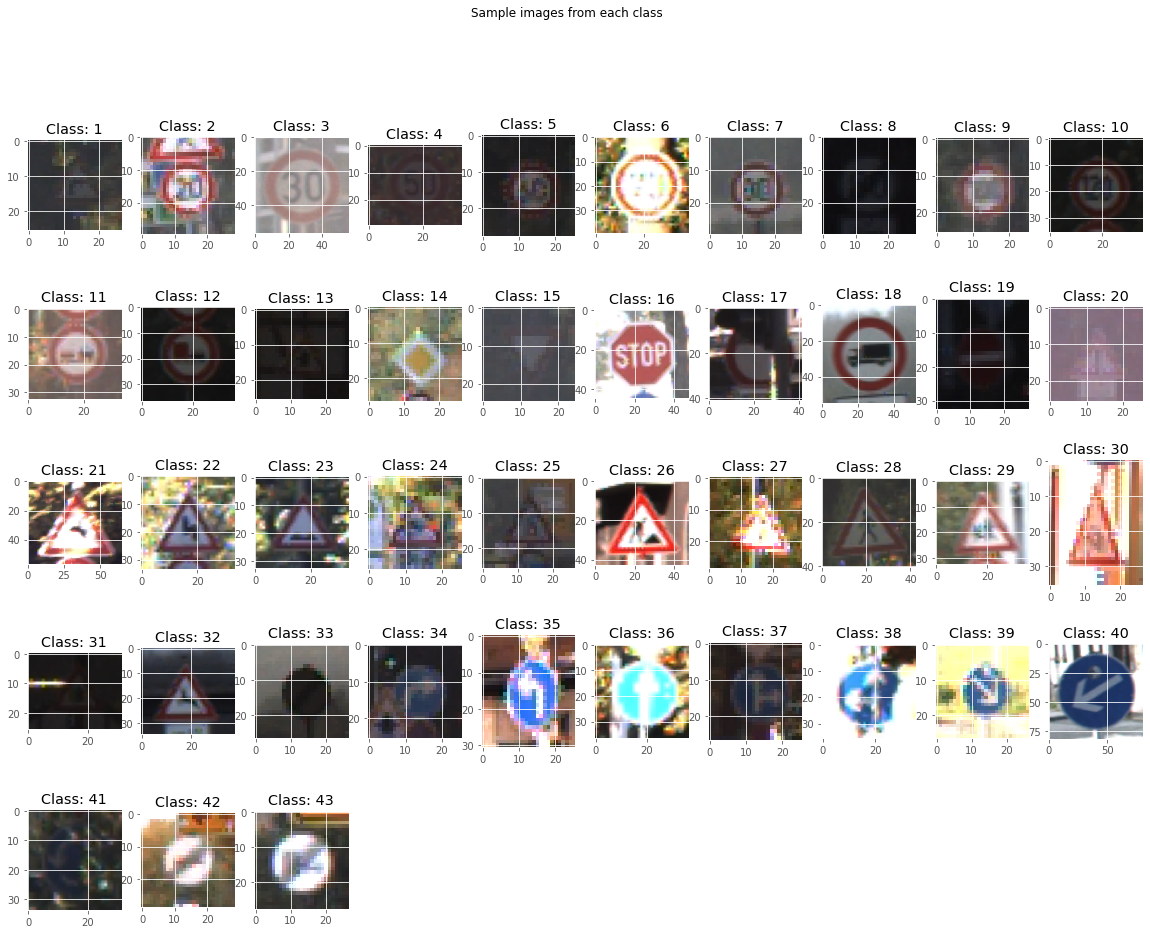

In [148]:
plt.figure(figsize=(20,15))
plt.suptitle('Sample images from each class')
columns = 10
for i, image in enumerate(imgs):
    plt.subplot(len(imgs) / columns + 1, columns, i + 1)
    plt.title(f'Class: {i+1}', color='black')
    plt.imshow(image)

# Data distribution

Displaying a bar chart which shows the distribution of class occurences within the dataset.

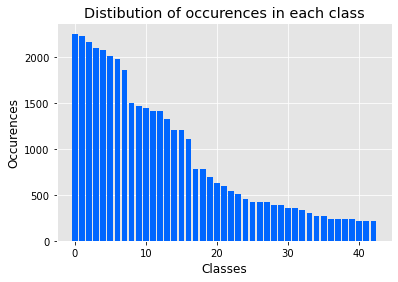

In [149]:
c = df_train['ClassId'].nunique()
x = df_train['ClassId'].value_counts()

plt.bar(x=x.index.sort_values(), height=x, color='#0066ff')
plt.title('Distibution of occurences in each class', color='black')
plt.xlabel("Classes", color='black')
plt.ylabel("Occurences", color='black')
plt.tick_params(colors='black')

# Custom Dataset
Create a custom dataset class with the proper methods for importing the data

In [150]:
class GTSR43Dataset(Dataset):
    """German Traffic Sign Recognition dataset."""
    def __init__(self, root_dir, train_file, transform=None):
        self.root_dir = root_dir
        self.train_file_path = train_file
        self.label_df = pd.read_csv(os.path.join(self.root_dir, self.train_file_path))
        self.transform = transform
        self.classes = list(self.label_df['ClassId'].unique())

    def __getitem__(self, idx):
        """Return (image, target) after resize and preprocessing."""
        img = os.path.join(self.root_dir, self.label_df.iloc[idx, 7])
        
        X = Image.open(img)
        y = self.class_to_index(self.label_df.iloc[idx, 6])

        if self.transform:
            X = self.transform(X)

        return X, y
    
    def class_to_index(self, class_name):
        """Returns the index of a given class."""
        return self.classes.index(class_name)
    
    def index_to_class(self, class_index):
        """Returns the class of a given index."""
        return self.classes[class_index] 
    
    def get_class_count(self):
        """Return a list of label occurences"""
        cls_count = dict(self.label_df.ClassId.value_counts())
#         cls_percent = list(map(lambda x: (1 - x / sum(cls_count)), cls_count))
        return cls_count
    
    def __len__(self):
        """Returns the length of the dataset."""
        return len(self.label_df)

class GTSR43Subset(GTSR43Dataset):
    """A subset helper class for splitting the main dataset"""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        """Retrieves one item from the dataset."""
        X, y = self.subset[idx]
        
        if self.transform:
            X = self.transform(X)

        return X, y

    def __len__(self):
        return len(self.subset)
    
class GTSR43Testset(Dataset):
    """German Traffic Sign Recognition dataset"""
    def __init__(self, root_dir, test_file, transform=None):
        self.root = root_dir
        self.test_file_path = test_file
        self.label_df = pd.read_csv(os.path.join(self.root_dir, self.test_file_path))
        self.transform = transform

    def __getitem__(self, idx):
        """Retrieves one item from the dataset."""
        img = os.path.join(self.root_dir, self.label_df.iloc[idx, 7])
        
        image = Image.open(img)

        if self.transform:
            image = self.transform(image)

        return image
    
    def __len__(self):
        return len(self.label_df)

Verify that the custom dataset and methods work

In [151]:
ds = GTSR43Dataset(dc.root_dir, dc.train_csv)
X, y = ds.__getitem__(5)
print(f'Train image: {X}\nTarget class: {y}\nClass count: {ds.get_class_count()}')

Train image: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=31x27 at 0x7F19AD5DE5D0>
Target class: 0
Class count: {2: 2250, 1: 2220, 13: 2160, 12: 2100, 38: 2070, 10: 2010, 4: 1980, 5: 1860, 25: 1500, 9: 1470, 7: 1440, 8: 1410, 3: 1410, 11: 1320, 18: 1200, 35: 1200, 17: 1110, 31: 780, 14: 780, 33: 689, 15: 630, 26: 600, 28: 540, 23: 510, 30: 450, 34: 420, 6: 420, 16: 420, 22: 390, 36: 390, 40: 360, 20: 360, 21: 330, 39: 300, 24: 270, 29: 270, 32: 240, 42: 240, 41: 240, 27: 240, 37: 210, 19: 210, 0: 210}


# Data augmentation
Helper functions for handling data augmenation.

In [152]:
def image_resize():
    """Transforms for resizing, cropping."""
    resize_transforms = transforms.Compose([transforms.Resize(32),
                                            transforms.CenterCrop(30),
                                           ])
    return resize_transforms

def image_preprocess():
    """Transforms for resizing, cropping, then converting to Tensor."""
    preprocess_transforms = transforms.Compose([transforms.Resize(32),
                                                transforms.CenterCrop(30),
                                                transforms.ToTensor()
                                               ])
    return preprocess_transforms

def common_transforms(mean, std):
    """Transforms which are common to both the train and test set.""" 
    common_transforms = transforms.Compose([image_preprocess(),
                                            transforms.Normalize(mean, std)
                                           ])
    return common_transforms

def data_aug(mean, std):
    """Data augmentation transforms."""
    data_aug_transforms = transforms.Compose([transforms.Resize(32),
                                              transforms.CenterCrop(30),
                                              transforms.RandomVerticalFlip(),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ColorJitter(),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean, std),
                                              transforms.RandomErasing(),
                                             ])        
    return data_aug_transforms

# Mean and Std Dev
Helper function for extracting the mean and std dev of the images in the dataset

In [153]:
# def get_mean_std():
#     """Gets mean and standard deviation."""  
#     ds = GTSR43Dataset(dc.root_dir, 
#                        dc.train_csv, 
#                        transform=image_preprocess())       
#     loader = DataLoader(ds, 
#                         batch_size = 10, 
#                         shuffle = False, 
#                         num_workers = 4)
    
#     mean = 0.0
#     std = 0.0
    
#     for images, _ in loader:
#         batch_samples = images.size(0) # the last batch can have smaller size
#         images = images.view(batch_samples, images.size(1), -1)
#         mean += images.mean(2).sum(0)
#         std += images.std(2).sum(0)

#     mean /= len(loader.dataset)
#     std /= len(loader.dataset)
    
#     return mean, std

# mean, std = get_mean_std()
# print(mean, std)

Helper function for loading the data into Train/Test subsets

In [154]:
def get_data(root_dir, batch_size, num_workers=4, data_augmentation=False):
    """Loads and splits data into train and test subsets. """  
    dataset = GTSR43Dataset(root_dir, dc.train_csv)
    
    if data_augmentation:
        X_transforms = data_aug(tc.mean, tc.std)
    else:
        X_transforms = common_transforms(tc.mean, tc.std)
    
    y_transforms = common_transforms(tc.mean, tc.std)
    
    X_size = int(0.8 * len(dataset))
    y_size = len(dataset) - X_size
    
    X_dataset, y_dataset = torch.utils.data.random_split(dataset, [X_size, y_size])
    
    X_subset = GTSR43Subset(X_dataset, X_transforms)
    y_subset = GTSR43Subset(y_dataset, y_transforms)

    X_loader = DataLoader(X_subset, 
                          batch_size=batch_size, 
                          shuffle=False,
                          num_workers=num_workers)  
    
    y_loader = DataLoader(y_subset,
                          batch_size=batch_size, 
                          shuffle=False, 
                          num_workers=num_workers)
    
    return X_loader, y_loader

Train function

In [155]:
def train(tc: TrainingConfig, 
          model: nn.Module, 
          optimizer: torch.optim.Optimizer,
          X_loader: torch.utils.data.DataLoader, 
          epoch_idx: int) -> None:
    
    model.train()
    
    batch_loss = np.array([])
    batch_acc = np.array([])
    
    for batch, (X, y) in enumerate(X_loader):
        
        if batch == 0:
            print(f'Device: {torch.cuda.get_device_name(0)}, Data: {X.shape}, Target: {y.shape}')       

        index_y = y.clone()
        X = X.to(tc.device)
        y = y.to(tc.device)
        
        optimizer.zero_grad()
        output = model(X)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        prob = F.softmax(output, dim=1)
        pred = prob.data.max(dim=1)[1]  
        correct = pred.cpu().eq(index_y).sum()
        acc = float(correct) / float(len(X))
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = 100. * batch_acc.mean()
    
    print(f'Training   - loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.2f}%')
    
    return epoch_loss, epoch_acc

Test Function

In [156]:
def validate(tc: TrainingConfig,
             model: nn.Module,
             y_loader: torch.utils.data.DataLoader) -> float:

    model.eval()
    
    loss = 0.0
    correct = 0.0
    for X, y in y_loader:
        index_y = y.clone()
        
        X = X.to(tc.device)
        y = y.to(tc.device)

        output = model(X)
        loss += F.cross_entropy(output, y).item()
        prob = F.softmax(output, dim=1)
        pred = prob.data.max(dim=1)[1] 
        correct += pred.cpu().eq(index_y).sum()

    loss = loss / len(y_loader)  
    accuracy = 100. * correct / len(y_loader.dataset)
    
    print(f'Validation - loss: {loss:.4f}, accuracy: {accuracy:.2f}%, {correct}/{len(y_loader.dataset)}')
    
    return loss, accuracy/100.0

Load pretrained model

In [157]:
def trainable_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)
            

def pretrained_net():        
    model_path = os.path.join(dc.model_dir, tc.model_name)
    try:
        model = torch.load('/kaggle/working/models/resnet50_3_pretrained.pt')
    except FileNotFoundError:
        os.environ['TORCH_HOME'] = '/kaggle/working/german_traffic_sign_recognition'
        model = models.resnet50(pretrained=True, progress=True)
        torch.save(model, '/kaggle/working/models/resnet50_pretrained.pt')
        model = torch.load('/kaggle/working/models/resnet50_pretrained.pt')
        
    for param in model.parameters():
        param.requires_grad = False
        
    model.fc = nn.Sequential(nn.Linear(2048, 512),
                             nn.ReLU(inplace=True),
                             nn.Dropout(0.5),
                             
                             nn.Linear(512, 512), 
                             nn.ReLU(inplace=True),
                             nn.Dropout(0.2),
                             
                             nn.Linear(512, tc.num_classes))
        
    layers = [
        model.layer2,
        model.layer3,
        model.layer4,
        model.avgpool,
      ]
    
    for layer in layers:
        for param in layer.parameters():
            param.requires_grad = True
    
    return model

pt_model = pretrained_net()

print("Layers: \n")
for name, child in pt_model.named_children():
    print(name)

print("\nCurrent Trainable Parameters: \n")
print(trainable_parameters(pt_model))

Layers: 

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc

Current Trainable Parameters: 

layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer2.1.conv3.weight
layer2.1.bn3.weight
layer2.1.bn3.bias
layer2.2.conv1.weight
layer2.2.bn1.weight
layer2.2.bn1.bias
layer2.2.conv2.weight
layer2.2.bn2.weight
layer2.2.bn2.bias
layer2.2.conv3.weight
layer2.2.bn3.weight
layer2.2.bn3.bias
layer2.3.conv1.weight
layer2.3.bn1.weight
layer2.3.bn1.bias
layer2.3.conv2.weight
layer2.3.bn2.weight
layer2.3.bn2.bias
layer2.3.conv3.weight
layer2.3.bn3.weight
layer2.3.bn3.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0

Load and Save functions

In [158]:
def save_model(model, device, accuracy):
    
    if not os.path.exists(dc.model_dir):
        os.makedirs(dc.model_dir)

    model_path = os.path.join(dc.model_dir, tc.model_name)

    if device == 'cuda':
        model.to('cpu')

    torch.save(model.state_dict(), model_path + '_retrained.pt' )

    if device == 'cuda':
        model.to('cuda')
    return

def load_model(model):
    
    model_path = os.path.join(dc.model_dir, tc.model_name)
    model.load_state_dict(torch.load(model_path + '_retrained.pt'))
    
    return model

Main function

In [159]:
def main(model, optimizer, tb_writer, scheduler = None, data_augmentation = True):

    if torch.cuda.is_available():
        tc.device = "cuda"
    else:
        tc.device = "cpu"
        batch_size_to_set = 10
        num_workers_to_set = 2
    
    model.to(tc.device)
    
    X_loader, y_loader = get_data(root_dir=dc.root_dir, 
                                  batch_size=tc.batch_size, 
                                  num_workers=tc.num_workers, 
                                  data_augmentation=tc.data_augmentation)
    
    best_loss = torch.tensor(np.inf)
    
    epoch_X_loss = np.array([])
    epoch_y_loss = np.array([])
    epoch_X_acc = np.array([])
    epoch_y_acc = np.array([])
    
    t_begin = time.time()      
                            
    for epoch in range(tc.epochs_count):
        print(f'\nEpoch: {epoch + 1}/{tc.epochs_count}')    
        
        X_loss, X_acc = train(tc=tc, 
                              model=model, 
                              optimizer=optimizer, 
                              X_loader=X_loader, 
                              epoch_idx=epoch)

        epoch_X_loss = np.append(epoch_X_loss, [X_loss])
        epoch_X_acc = np.append(epoch_X_acc, [X_acc])
                                
        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(X_loader)
        eta = speed_epoch * tc.epochs_count - elapsed_time

        tb_writer.add_scalar('Loss/Train', X_loss, epoch)
        tb_writer.add_scalar('Accuracy/Train', X_acc, epoch)
        tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch)
        tb_writer.add_scalar('Time/speed_epoch', speed_epoch, epoch)
        tb_writer.add_scalar('Time/speed_batch', speed_batch, epoch)
        tb_writer.add_scalar('Time/eta', eta, epoch)
                             
        if epoch % tc.test_interval == 0:

            current_loss, current_acc = validate(tc, model, y_loader)
                                                 
            epoch_y_loss = np.append(epoch_y_loss, [current_loss])
            epoch_y_acc = np.append(epoch_y_acc, [current_acc])
                                    
            if current_loss < best_loss:
                best_loss = current_loss
                save_model(model, device = tc.device, accuracy = current_acc)
                print('Model Improved! Saved!')

            tb_writer.add_scalar('Loss/Validation', current_loss, epoch)
            tb_writer.add_scalar('Accuracy/Validation', current_acc, epoch)
            tb_writer.add_scalars('Loss/train-val', {'train': X_loss, 'validation': current_loss}, epoch)
            tb_writer.add_scalars('Accuracy/train-val', {'train': X_acc,'validation': current_acc}, epoch)
                                  
        if scheduler is not None:
            scheduler.step()  

        print(f'Time: {elapsed_time:.2f}s, {speed_epoch:.2f} s/epoch, {speed_batch:.2f} s/batch, Learning rate: {scheduler.get_last_lr()[0]}') 
        
    print(f'Total time: {time.time() - t_begin:.2f}, Best loss: {best_loss:.3f}')    
    
    return model, epoch_X_loss, epoch_X_acc, epoch_y_loss, epoch_y_acc

Putting it all together

In [160]:
model = pretrained_net()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=oc.init_learning_rate,
                             weight_decay=oc.weight_decay)

scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=oc.scheduler_step_size, 
                                      gamma=oc.scheduler_gamma)

print(f'Device: {tc.device}\n\
Epochs: {tc.epochs_count}\n\
Batch size: {tc.batch_size}\n\
Data Augmentation: {tc.data_augmentation}\n\
Scheduler step size: {oc.scheduler_step_size}\n\
Scheduler gamma: {oc.scheduler_gamma}\n\
Learning rate: {oc.init_learning_rate}\n\
L2 weight decay: {oc.weight_decay}')

model, train_loss, train_acc, val_loss, val_acc = main(model, 
                                                       optimizer, 
                                                       tb_writer, 
                                                       scheduler=scheduler, 
                                                       data_augmentation=tc.data_augmentation)

Device: cuda
Epochs: 12
Batch size: 32
Data Augmentation: False
Scheduler step size: 6
Scheduler gamma: 0.1
Learning rate: 0.0001
L2 weight decay: 0.0001

Epoch: 1/12
Device: Tesla P100-PCIE-16GB, Data: torch.Size([32, 3, 30, 30]), Target: torch.Size([32])
Training   - loss: 1.1641, accuracy: 66.84%
Validation - loss: 0.1638, accuracy: 94.81%, 7435.0/7842
Model Improved! Saved!
Time: 56.04s, 56.04 s/epoch, 0.06 s/batch, Learning rate: 0.0001

Epoch: 2/12
Device: Tesla P100-PCIE-16GB, Data: torch.Size([32, 3, 30, 30]), Target: torch.Size([32])
Training   - loss: 0.1631, accuracy: 95.67%
Validation - loss: 0.0769, accuracy: 98.02%, 7687.0/7842
Model Improved! Saved!
Time: 121.08s, 60.54 s/epoch, 0.06 s/batch, Learning rate: 0.0001

Epoch: 3/12
Device: Tesla P100-PCIE-16GB, Data: torch.Size([32, 3, 30, 30]), Target: torch.Size([32])
Training   - loss: 0.0814, accuracy: 97.88%
Validation - loss: 0.0489, accuracy: 98.74%, 7743.0/7842
Model Improved! Saved!
Time: 185.70s, 61.90 s/epoch, 0.06